In [2]:
# 数据处理
# 完成类别名称对数字的映射

INSECT_NAMES = ['Boerner', 'Leconte', 'Linnaeus', 
                'acuminatus', 'armandi', 'coleoptera', 'linnaeus']


def get_insect_names():
    """
    返回一个字典，实现名字和label的对应
        {'Boerner': 0,
         'Leconte': 1,
         'Linnaeus': 2, 
         'acuminatus': 3,
         'armandi': 4,
         'coleoptera': 5,
         'linnaeus': 6
        }

    """
    insect_category2id = {}
    for i, item in enumerate(INSECT_NAMES):
        insect_category2id[item] = i

    return insect_category2id


In [3]:
cname2cid = get_insect_names()
cname2cid

{'Boerner': 0,
 'Leconte': 1,
 'Linnaeus': 2,
 'acuminatus': 3,
 'armandi': 4,
 'coleoptera': 5,
 'linnaeus': 6}

In [4]:
import os 
import numpy as np
import xml.etree.ElementTree as ET

# 传入一个字典和文件路径,读取xml文件下所有的文件信息
def get_annotations(cname2cid, datadir):
    filenames = os.listdir(os.path.join(datadir, 'annotations', 'xmls'))
    records = []
    ct = 0
    for fname in filenames: # fname 就是1.xml这样的名字
        fid = fname.split('.')[0]  # 就是以'.'为分割的
        fpath = os.path.join(datadir, 'annotations', 'xmls', fname)
        img_file = os.path.join(datadir, 'images', fid + '.jpeg')
        tree = ET.parse(fpath)  # 解析xmls

        if tree.find('id') is None:
            im_id = np.array([ct]) # 没找到就直接计数
        else:
            im_id = np.array([int(tree.find('id').text)])

        # 提取物体的宽度和高度信息
        objs = tree.findall('object')
        im_w = float(tree.find('size').find('width').text)
        im_h = float(tree.find('size').find('height').text)
        # 初始化信息，边界框，类别，是否拥挤，是否困难
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)
        gt_class = np.zeros((len(objs), ), dtype=np.int32)
        is_crowd = np.zeros((len(objs), ), dtype=np.int32)
        difficult = np.zeros((len(objs), ), dtype=np.int32)
        for i, obj in enumerate(objs):
            cname = obj.find('name').text
            gt_class[i] = cname2cid[cname]
            _difficult = int(obj.find('difficult').text)
            x1 = float(obj.find('bndbox').find('xmin').text)
            y1 = float(obj.find('bndbox').find('ymin').text)
            x2 = float(obj.find('bndbox').find('xmax').text)
            y2 = float(obj.find('bndbox').find('ymax').text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            # 这里使用xywh格式来表示目标物体真实框
            gt_bbox[i] = [(x1+x2)/2.0 , (y1+y2)/2.0, x2-x1+1., y2-y1+1.]
            is_crowd[i] = 0
            difficult[i] = _difficult

            
        voc_rec = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
        
        if len(objs) != 0:
            records.append(voc_rec)
        ct+=1
    return records

    

In [5]:
TRAINDIR = 'E:\Myproject\DataSet/3.6INSECT\insects\\train'
TESTDIR = 'E:\Myproject\DataSet/3.6INSECT\insects\\test'
VALIDDIR = 'E:\Myproject\DataSet/3.6INSECT\insects\\val'
cname2cid = get_insect_names()
records = get_annotations(cname2cid, TRAINDIR)
print('records num:{}\n recored[0]:{}'.format(len(records), records[0]))


records num:1693
 recored[0]:{'im_file': 'E:\\Myproject\\DataSet/3.6INSECT\\insects\\train\\images\\1.jpeg', 'im_id': array([0]), 'h': 1344.0, 'w': 1344.0, 'is_crowd': array([0, 0, 0, 0, 0]), 'gt_class': array([1, 0, 6, 4, 5]), 'gt_bbox': array([[542.5, 652.5, 140. , 150. ],
       [885. , 572. , 127. , 135. ],
       [648.5, 811.5,  84. ,  62. ],
       [798.5, 821. ,  86. ,  71. ],
       [667.5, 521. ,  88. ,  67. ]], dtype=float32), 'gt_poly': [], 'difficult': array([0, 0, 0, 0, 0])}


In [6]:
import cv2
# 传入边界框，然后最多对50个检测
def get_bbox(gt_bbox, gt_class):
    # 对于一般的检测任务，一张图片上会有多个目标物体
    # 设置参数MAX_NUM=50，即一张图片最多取50个真实框
    MAX_NUM = 50
    gt_bbox2 = np.zeros((MAX_NUM, 4))
    gt_class2 = np.zeros((MAX_NUM,))
    for i in range(len(gt_bbox)):
        gt_bbox2[i,:] = gt_bbox[i, :]
        gt_class2[i] = gt_class[i]
        if i >=MAX_NUM:
            break
    return gt_bbox2, gt_class2

def get_img_data_from_file(record):
    """
    record is a dict as following,
      record = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
    """
    im_file = record['im_file']  # 对应的图片文件
    h = record['h']
    w = record['w']
    is_crowd = record['is_crowd']
    gt_class = record['gt_class']
    gt_bbox = record['gt_bbox']
    difficult = record['difficult']
    print(im_file)

    img = cv2.imread(im_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    assert img.shape[0] == int(h), \
             "image height of {} inconsistent in record({}) and img file({})".format(
               im_file, h, img.shape[0])

    assert img.shape[1] == int(w), \
             "image width of {} inconsistent in record({}) and img file({})".format(
               im_file, w, img.shape[1])
    
    gt_boxes, gt_labels = get_bbox(gt_bbox, gt_class)

    # gt_bbox 用相对值
    gt_boxes[:, 0] = gt_boxes[:, 0] / float(w)
    gt_boxes[:, 1] = gt_boxes[:, 1] / float(h)
    gt_boxes[:, 2] = gt_boxes[:, 2] / float(w)
    gt_boxes[:, 3] = gt_boxes[:, 3] / float(h)
  
    return img, gt_boxes, gt_labels, (h, w)

In [7]:

record = records[0]
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
print('img shape:{}, \n gt_labels:{}, \n scales:{}\n'.format(img.shape, gt_labels, scales))

E:\Myproject\DataSet/3.6INSECT\insects\train\images\1.jpeg
img shape:(1344, 1344, 3), 
 gt_labels:[1. 0. 6. 4. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], 
 scales:(1344.0, 1344.0)



read image from fileE:\Myproject\DataSet/3.6INSECT\insects\train\images\1.jpeg


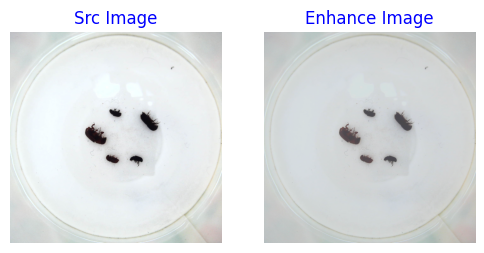

In [8]:

import numpy as np
import cv2
from PIL import Image, ImageEnhance
import random

# 随机改变亮度、对比度、颜色
def random_distort(img):
    def random_brightness(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Brightness(img).enhance(e)
    
    def random_contract(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Contrast(img).enhance(e)
    
    def random_color(img, lower=0.5, uppper=1.5):
        e = np.random.uniform(lower, uppper)
        return ImageEnhance.Color(img).enhance(e)
    
    ops = [random_brightness, random_contract, random_color]
    np.random.shuffle(ops)

    img = Image.fromarray(img)
    img = ops[0](img)
    img = ops[1](img)
    img = ops[2](img)
    img = np.asarray(img)

    return img

# 定义可视化函数，用于对比原图和图像增强效果
import matplotlib.pyplot as plt
%matplotlib inline
def visualize(srcimg, img_enhance):
    # 图像可视化
    plt.figure(num=2, figsize=(6, 12))
    plt.subplot(1,2,1)

    plt.title('Src Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(srcimg) # 显示原图片

    # 对原图做 随机改变亮暗、对比度和颜色等 数据增强
    srcimg_gtbox = records[0]['gt_bbox']
    srcimg_label = records[0]['gt_class']

    plt.subplot(1,2,2)
    plt.title('Enhance Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(img_enhance)
    
image_path = records[0]['im_file']
print(f'read image from file{image_path}')
srcimg = Image.open(image_path)
srcimg = np.array(srcimg)

img_enhance = random_distort(srcimg)
visualize(srcimg, img_enhance)

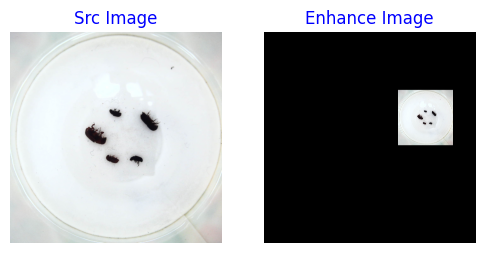

In [11]:
# 随机填充
def random_expand(img,
                  gtboxes,
                  max_ratio=4,  # 最大填充倍数
                  fill=None,  # 填充颜色
                  keep_ratio=True,  # 水平和垂直保持相同倍数
                  thresh=0.5):
    if random.random() > thresh:  # 随机数大于这个，就不会填充
        return img, gtboxes
    
    if max_ratio < 1.0:
        return img, gtboxes

    h, w, c = img.shape
    ratio_x = random.uniform(1, max_ratio)
    if keep_ratio:
        ratio_y = ratio_x
    else:
        ratio_y = random.uniform(1, max_ratio)
    # 新高度
    oh = int(h * ratio_y)
    ow = int(w * ratio_x)
    off_x = random.randint(0, ow-w)
    off_y = random.randint(0, oh - h)

    out_img = np.zeros((oh, ow, c))
    if fill and len(fill) == c:
        for i in range(c):
            out_img[:,:,i] = fill[i] * 255.0
    
    out_img[off_y:off_y+h, off_x:off_x+w,:] = img
    gtboxes[:,0] = ((gtboxes[:,0] * w) + off_x) / float(ow)
    gtboxes[:, 1] = ((gtboxes[:, 1] * h) + off_y) / float(oh)
    gtboxes[:, 2] = gtboxes[:, 2] / ratio_x
    gtboxes[:, 3] = gtboxes[:, 3] / ratio_y

    return out_img.astype('uint8'), gtboxes

srcimg_gtbox = records[0]['gt_bbox']
srcimg_label = records[0]['gt_class']

img_enhance, new_gtbox = random_expand(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)
    

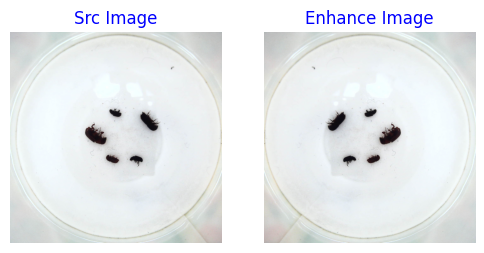

In [15]:
# 随即翻转
def random_flip(img, gt_boxes, thersh=0.5):
    if random.random() > thersh:
        img = img[:,::-1,:]
        gt_boxes[:,0] = 1.0 -gt_boxes[:,0]
    return img, gt_boxes

img_enhance, box_enhance = random_flip(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)



In [ ]:
# 随机打乱真实框的排列顺序
# 随机打乱真实框排列顺序
def shuffle_gtbox(gtbox, gtlabel):
    gt = np.concatenate(
        [gtbox, gtlabel[:, np.newaxis]], axis=1)
    idx = np.arange(gt.shape[0])
    np.random.shuffle(idx)
    gt = gt[idx, :]
    return gt[:, :4], gt[:, 4]